# Task

### Pre-defined code

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

# Downloading all the required libraries


# Importing all the required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import style
from glob import glob
from natsort import natsorted
from tqdm import tqdm
style.use('ggplot')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Loading all the images in the drive
gt_images = []
for files in tqdm(natsorted(glob('/content/drive/My Drive/ES666CV/Images/B/*'))):
    gt_images.append(cv2.imread(files, 1))
gt_images = np.array(gt_images)


100%|██████████| 6/6 [00:00<00:00, 121.37it/s]


In [ ]:
def show_image_grid(images, M, N, title='Title', figsize=8):
    # Assuming 'images' is a numpy array of shape (num_images, height, width, channels)
    if M==1:
        row_size = figsize
        col_size = figsize//4
    elif N==1:
        row_size = figsize//4
        col_size = figsize
    else:
        row_size, col_size = figsize, figsize

    fig, axes = plt.subplots(M, N, figsize=(row_size, col_size))

    if len(images.shape) < 4:
        images = np.expand_dims(images.copy(), axis=0)

    fig.suptitle(title)
    for i in range(M):
        for j in range(N):
            if M==1 and N==1:
                ax = axes
            elif M == 1 or N==1:
                ax = axes[max(i, j)]
            else:
                ax = axes[i, j]
            index = i * N + j
            if index < images.shape[0]:
                ax.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
            ax.axis('off')
    plt.tight_layout()
    plt.show()

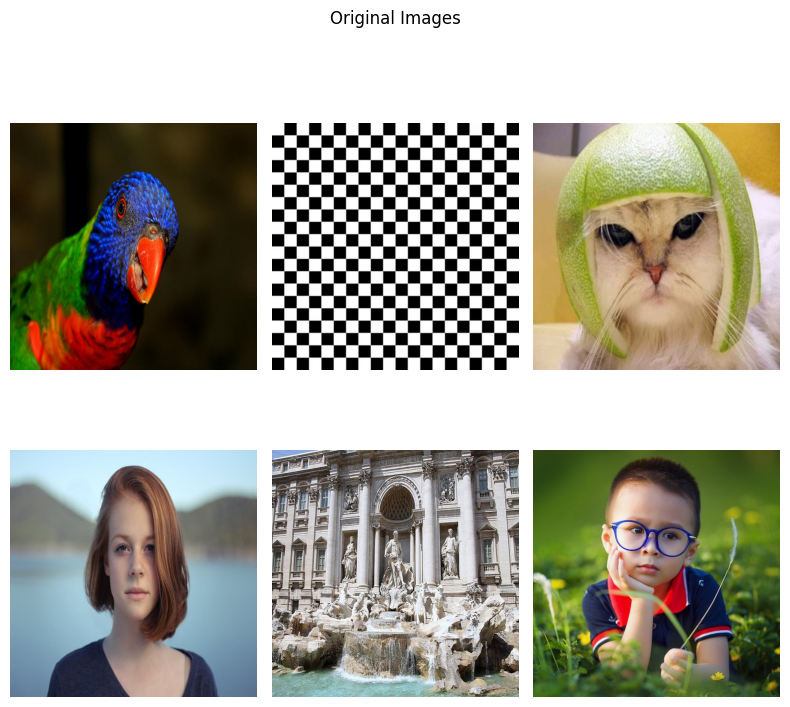

In [ ]:
show_image_grid(gt_images, 2, 3, 'Original Images', figsize=8)

### Q1 [2 Marks]

Implement Gaussian Pyramid Downsampling method from scratch.Compare it with Opencv resize method. What difference do you observe when you resize an image with Gaussian Pyramid approach and Opencv approach.

References:
1. [Gaussian & Laplacian pyramid	construction](https://www.cs.toronto.edu/~mangas/teaching/320/slides/CSC320L10.pdf)
2. [Multi-Scale Representation](https://medium.com/jun94-devpblog/cv-4-multi-scale-representation-gaussian-and-laplacian-pyramid-527ca4c4831c)

In [ ]:
def pad_image_to_divisible(image, K, pad_value=0):
    # Get the original image dimensions
    h, w = image.shape[:2]

    # Calculate the padding needed for height and width
    pad_h = (K - (h % K)) % K  # Padding needed for height
    pad_w = (K - (w % K)) % K  # Padding needed for width

    # Compute the padding to add to top/bottom and left/right
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left

    # Pad the image: (top, bottom), (left, right), and (no padding on channels)
    if len(image.shape) == 3:  # For RGB images
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),
                              mode='constant', constant_values=pad_value)
    else:  # For grayscale images
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)),
                              mode='constant', constant_values=pad_value)

    return padded_image

In [ ]:
from scipy.ndimage import convolve

def gaussian_smoothing(image, kernel_size=5, sigma=1.0):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

# Downsampling function
def downsample(image):
    return image[::2,::2,:]

def gaussian_pyramid(image, levels):
    pyramid = [image]
    for i in range(levels - 1):
        # Apply Gaussian blur and downsample by a factor of 2
        smoothed_image = gaussian_smoothing(pyramid[-1], kernel_size=5, sigma=1.0)
        downsampled_image = downsample(smoothed_image)

        # Ensure the image size is divisible by original image size at the first level
        image = pad_image_to_divisible(downsampled_image, pyramid[0].shape[0])
        pyramid.append(image)

    return np.array(pyramid)

def opencv_resize(inp_image, levels):
    pyramid = []
    h, w    = inp_image.shape[:2]
    for i in range(levels):
        # Apply Gaussian blur and downsample by a factor of 2
        # Write code here
        image = cv2.resize(inp_image, (h//2**i, w//2**i))

        image = pad_image_to_divisible(image, min(h, w))
        pyramid.append(image)

    return np.array(pyramid)

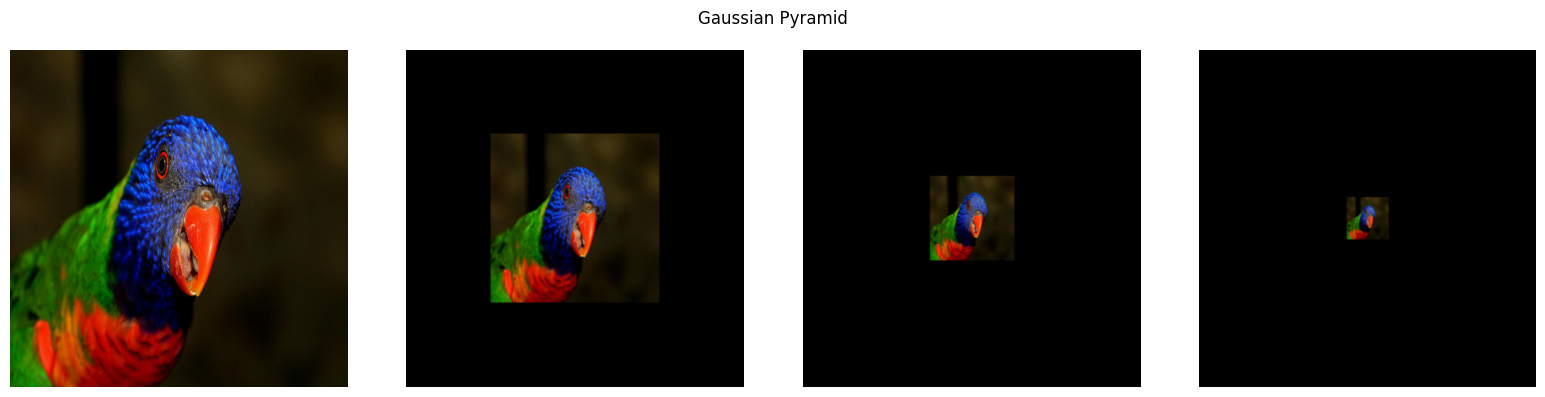

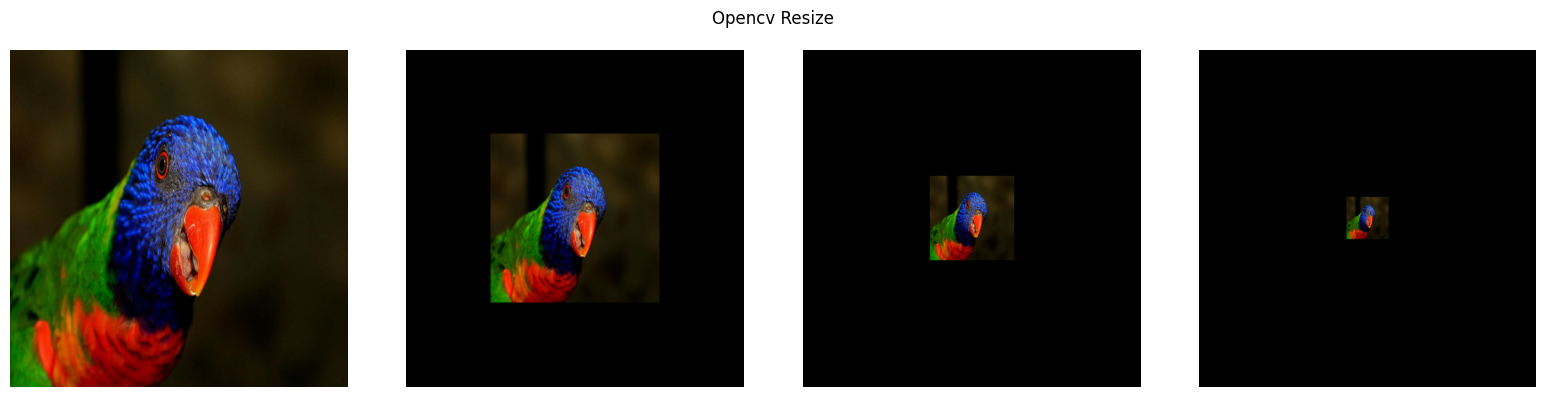

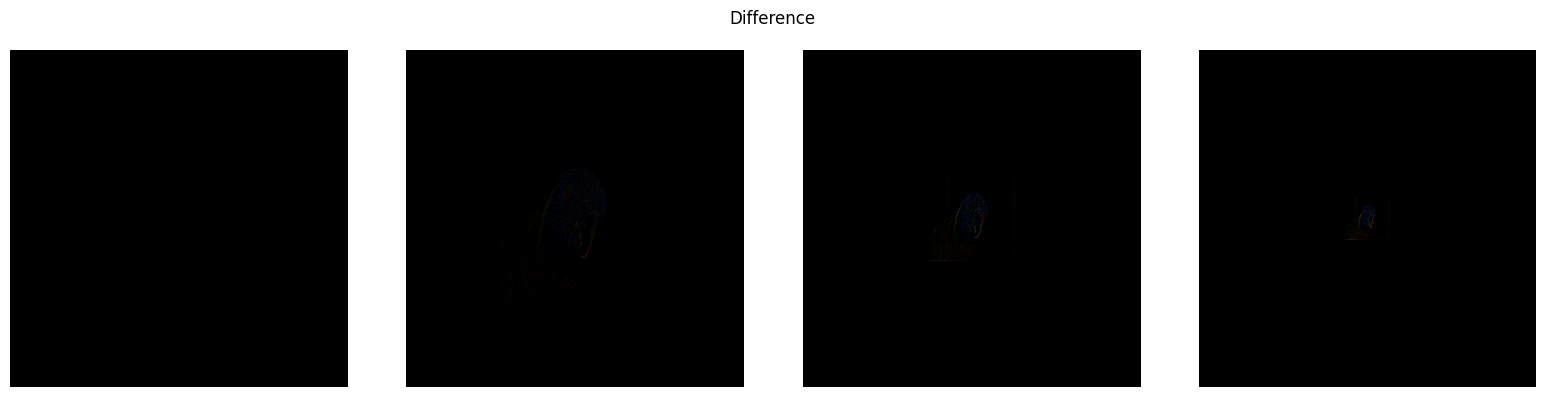

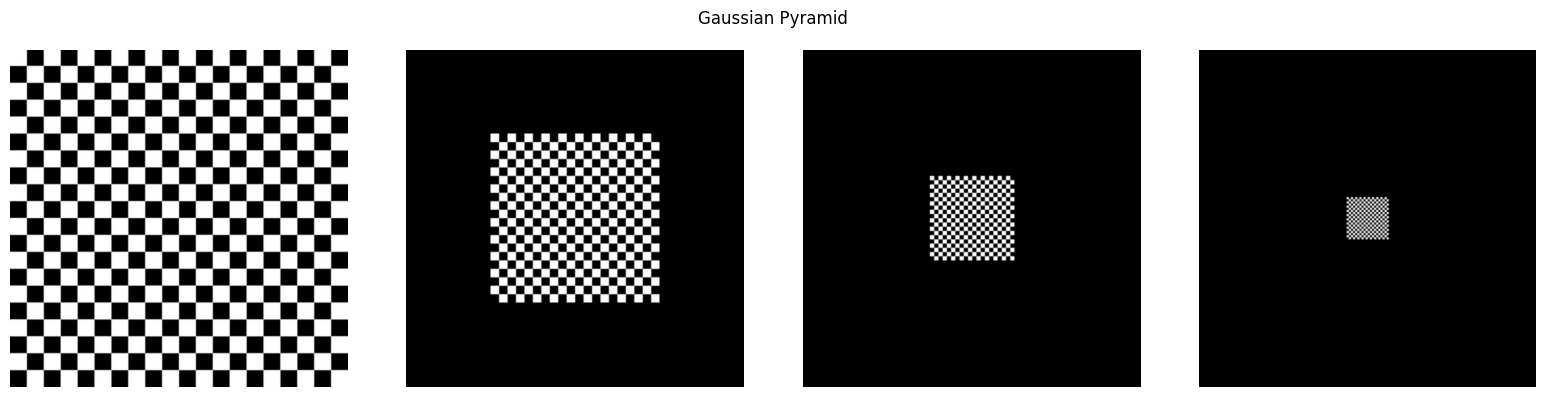

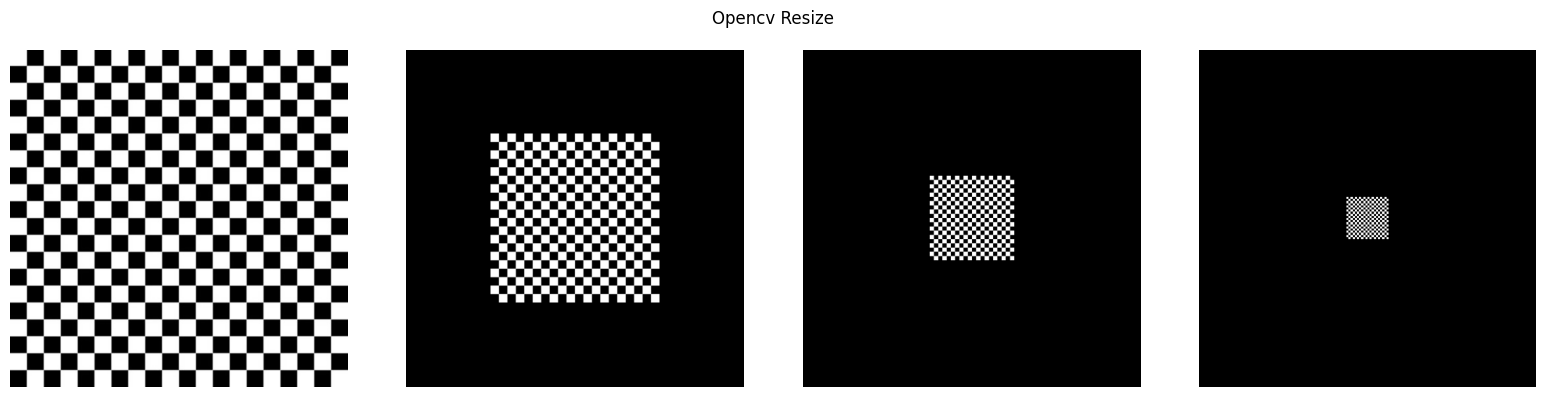

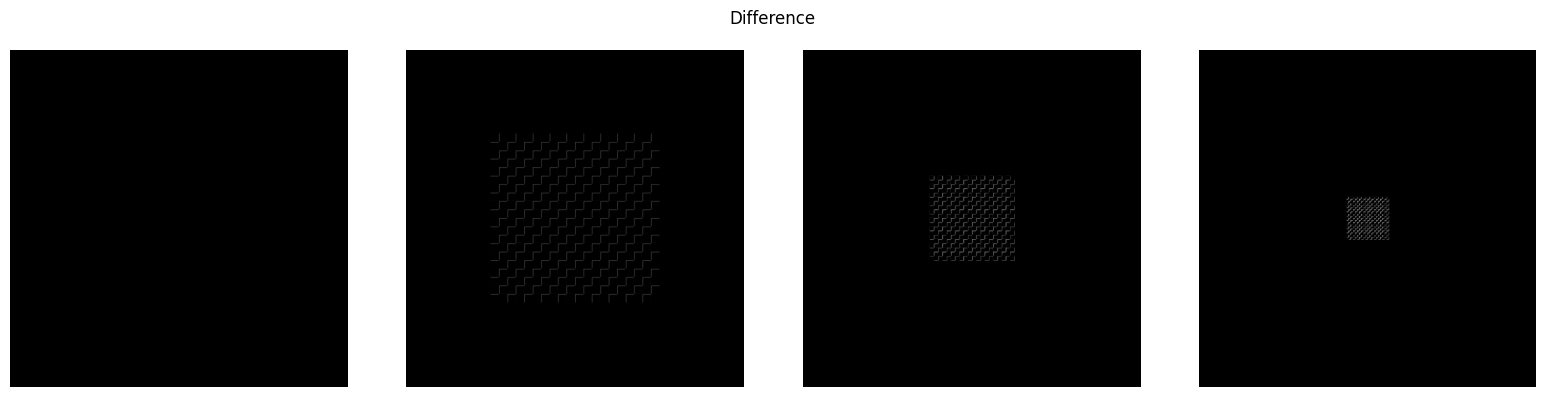

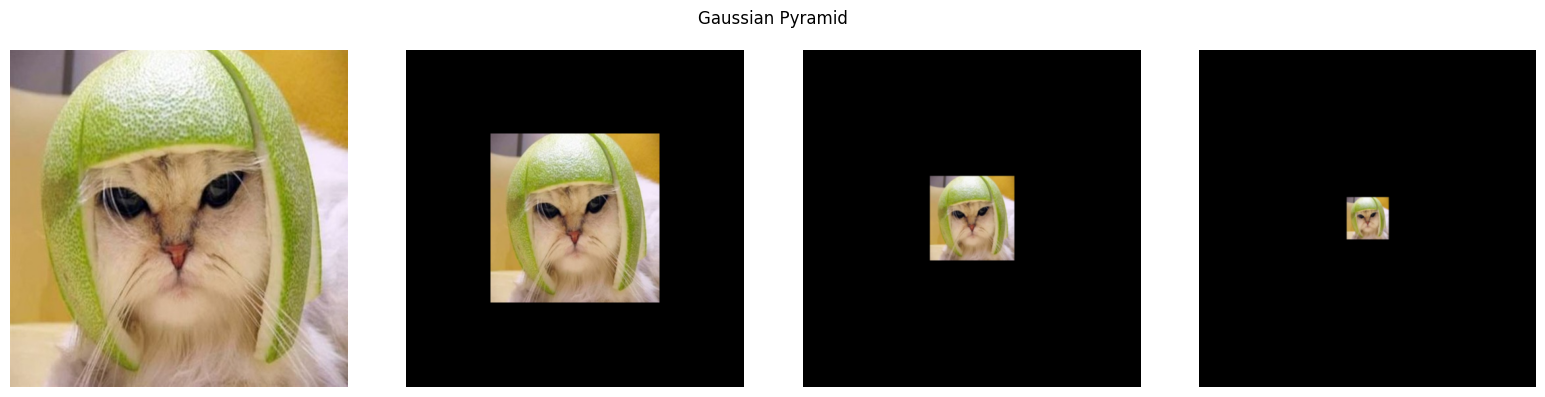

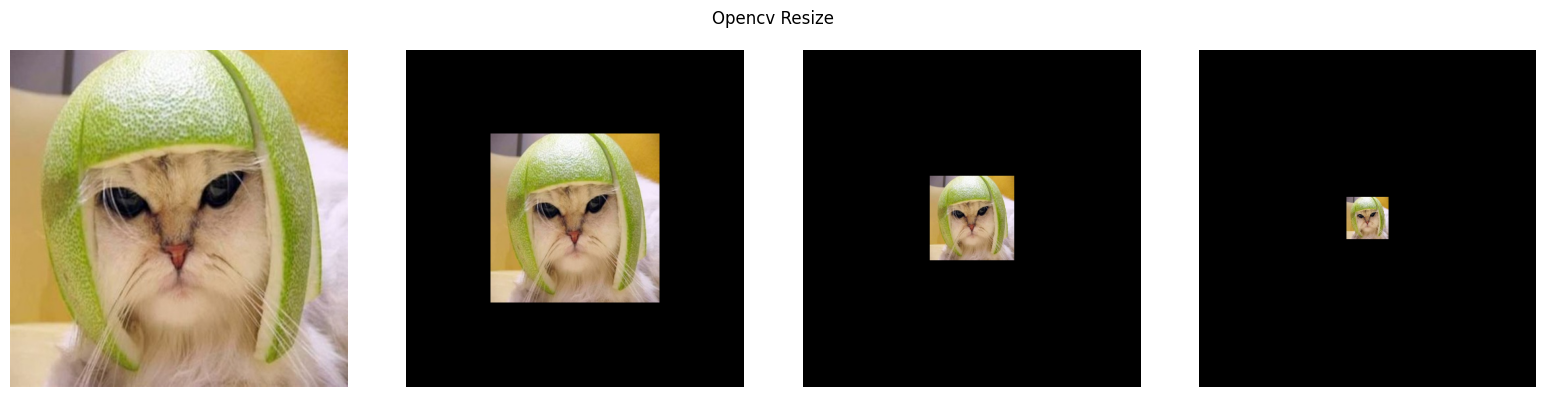

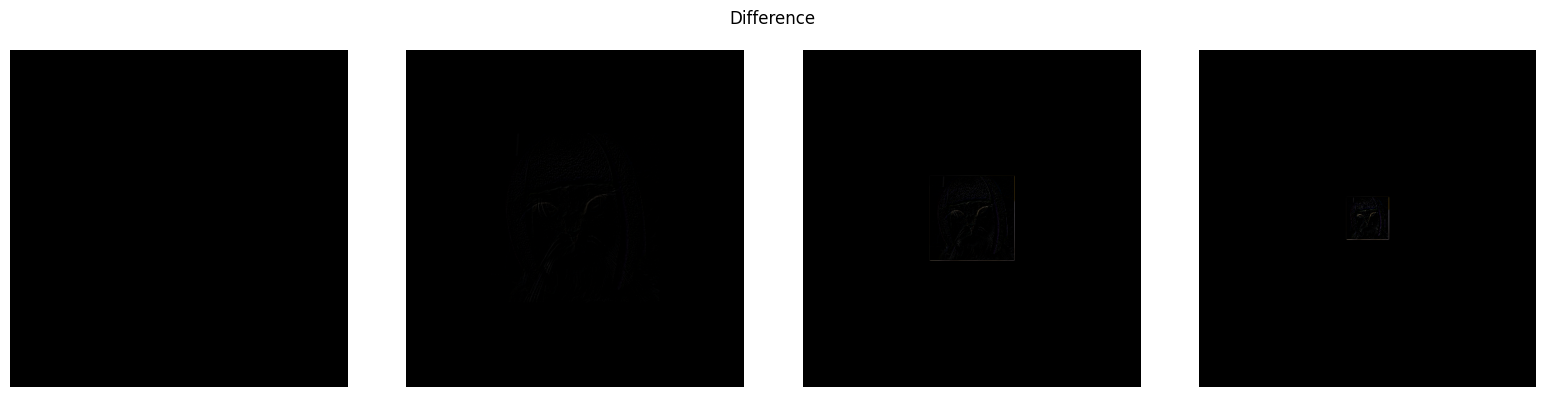

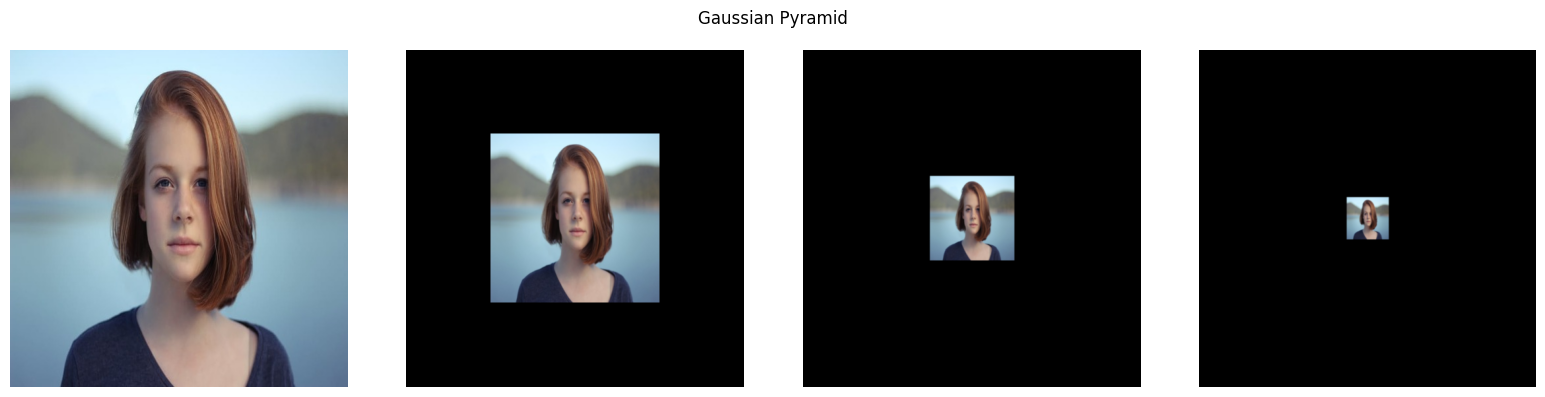

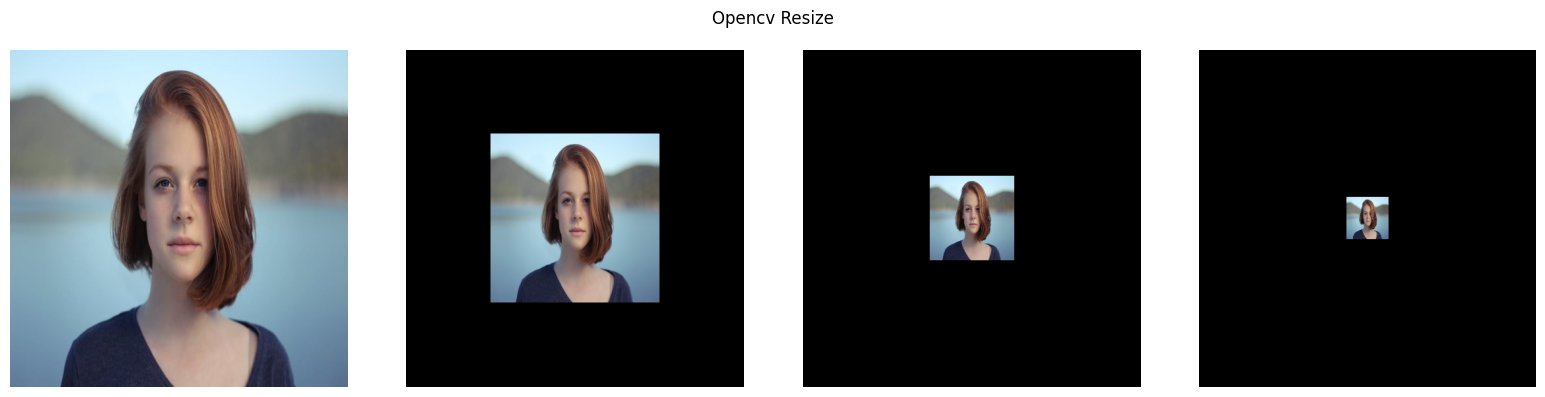

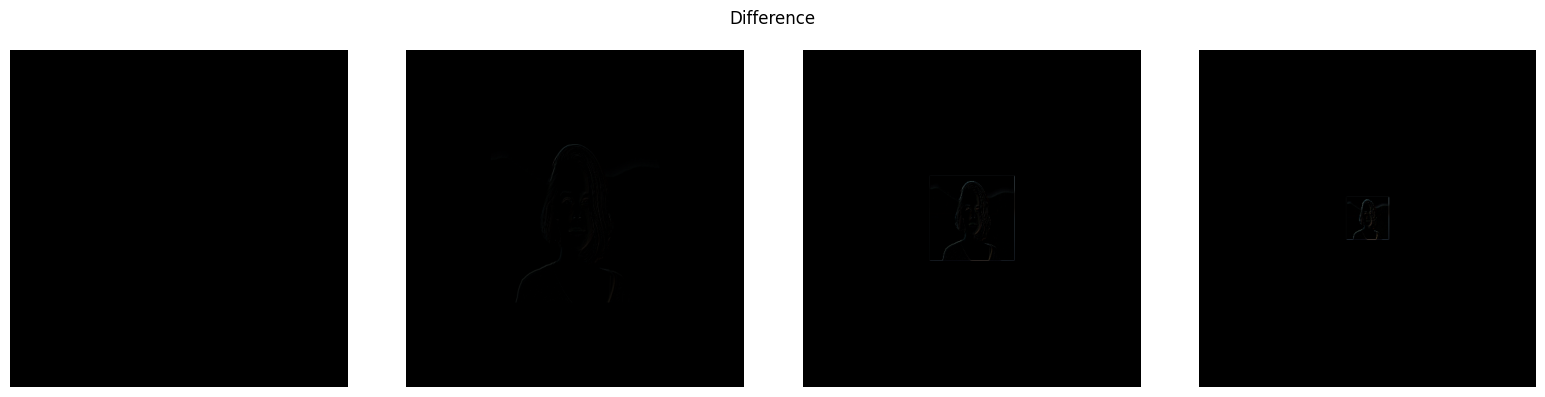

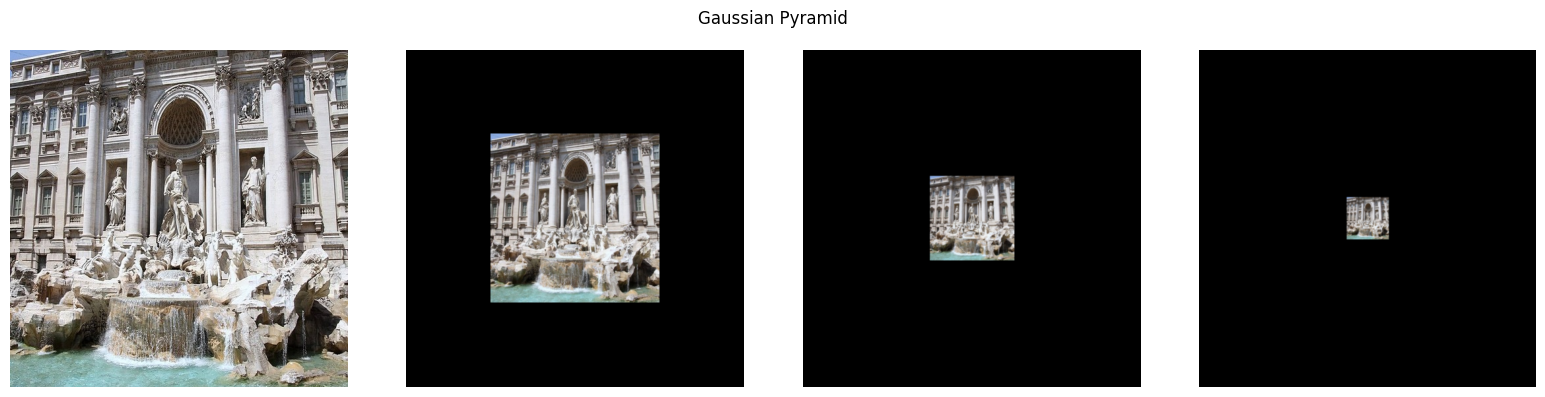

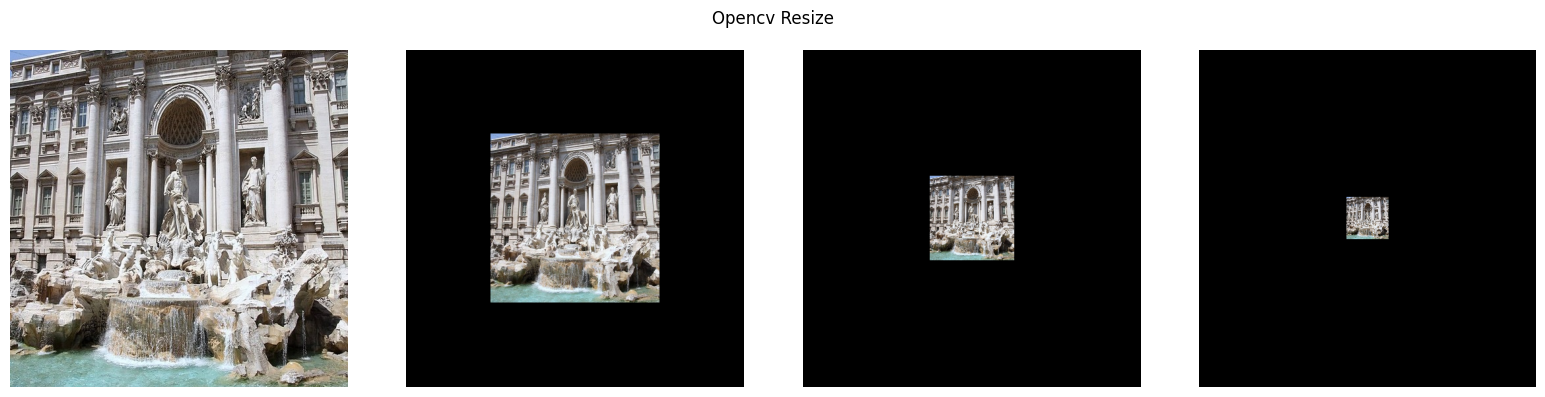

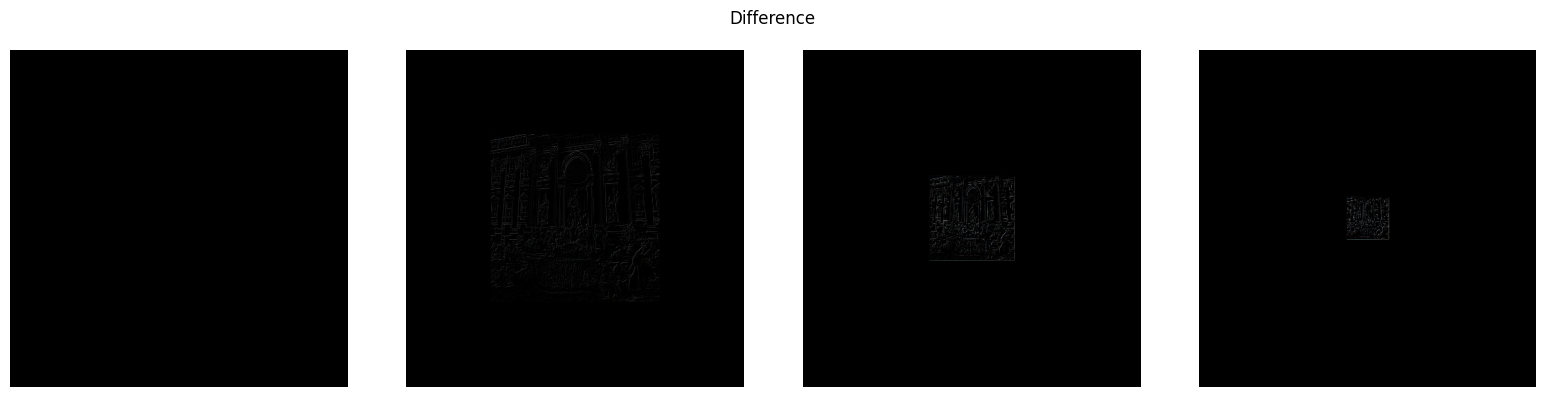

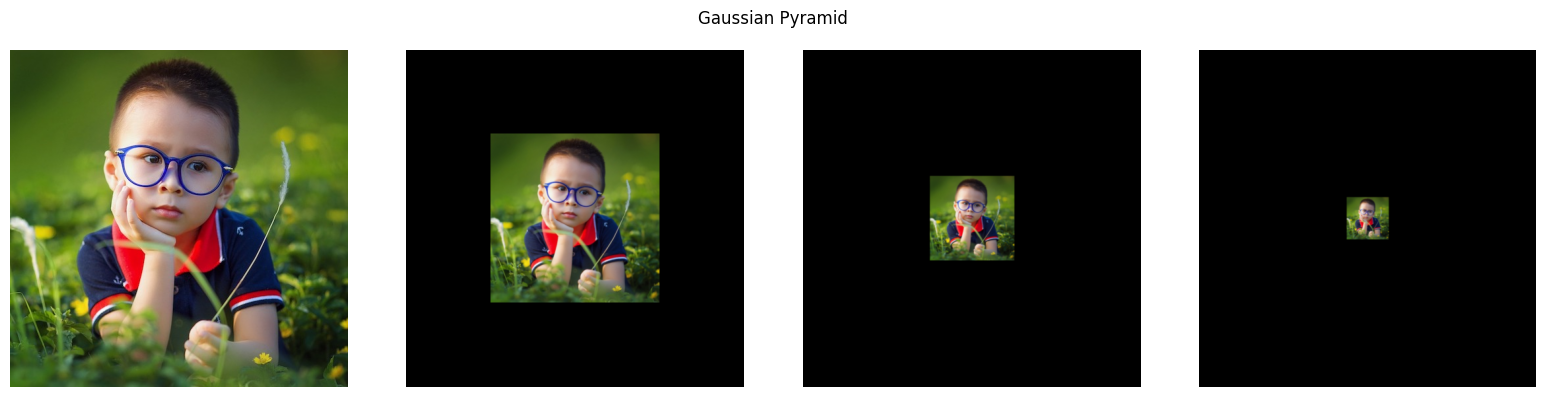

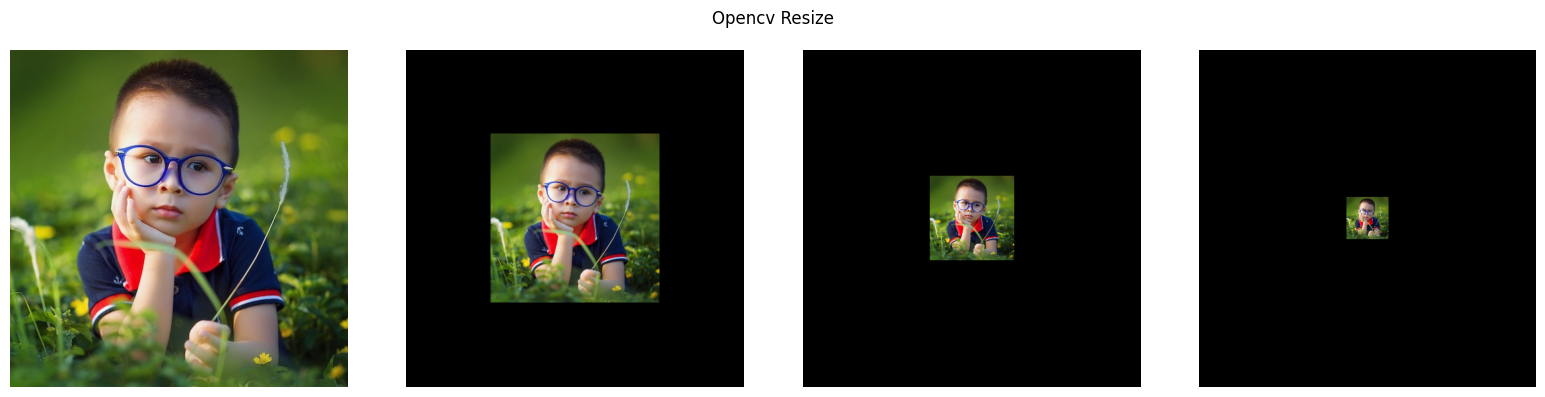

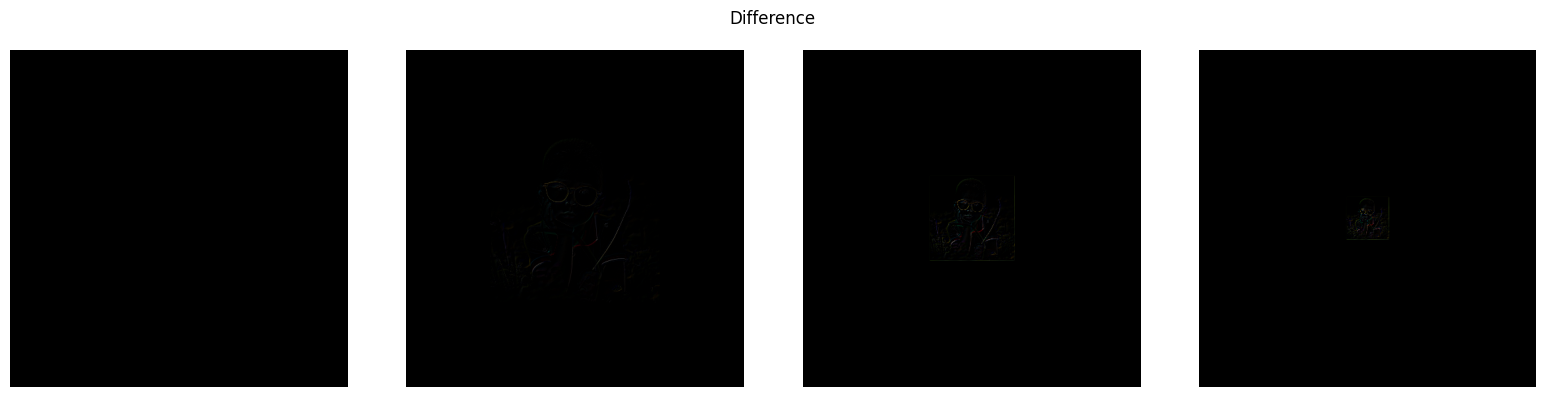

In [ ]:
for idx, image in enumerate(gt_images):

    # Generate pyramid of images for matching
    s_image_pyramids = gaussian_pyramid(image, levels=4)
    s_image_opecv_resize = opencv_resize(image, levels=4)

    diff = []
    for gauss_img, open_img in zip(s_image_pyramids, s_image_opecv_resize):
        diff.append(cv2.subtract(gauss_img, open_img))
    diff = np.array(diff)

    show_image_grid(s_image_pyramids, 1, 4, 'Gaussian Pyramid', figsize=16)
    show_image_grid(s_image_opecv_resize, 1, 4, 'Opencv Resize', figsize=16)
    show_image_grid(diff, 1, 4, 'Difference', figsize=16)

### Q2 [4 Marks]

You have to implement image blending technique using Laplacian Pyramids from scratch.

You can use following functions from opencv/scipy:

* convolution
* cv2.subtract
* cv2.add
* cv2.resize
* padding

You can follow this article for more explanation:

1. [Image Blending Using Laplacian Pyramids](https://becominghuman.ai/image-blending-using-laplacian-pyramids-2f8e9982077f)

In [ ]:
def downsample(image):
    return image[::2, ::2]      # taking every second pixel from the image

def upsample(image):
    return cv2.resize(image, (image.shape[1] * 2, image.shape[0] * 2), interpolation=cv2.INTER_LINEAR)    # Upsampling the image by a factor of 2

def gaussian_smoothing(image, kernel_size=5, sigma=1.0):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

def gaussian_pyramid(image, levels):
    pyramid = [image]
    for i in range(levels - 1):

        smoothed_image = gaussian_smoothing(pyramid[-1], kernel_size=5, sigma=1.0)  # applying gaussian smoothing on the image
        downsampled_image = downsample(smoothed_image)
        pyramid.append(downsampled_image)  # Append the downsampled image

    return pyramid

def laplacian_pyramid(gaussian_pyramid):
    pyramid = []
    for i in range(len(gaussian_pyramid) - 1):
        upsample_image = upsample(gaussian_pyramid[i + 1])
        laplacian = cv2.subtract(gaussian_pyramid[i], upsample_image)
        pyramid.append(laplacian)  # Ensure we're appending to the correct list

    pyramid.append(gaussian_pyramid[-1])
    return pyramid


def blend_pyramids(laplacianA, laplacianB, mask_pyramid):
    blended_pyramid = []
    for La, Lb, mask in zip(laplacianA, laplacianB, mask_pyramid):

        mask_expanded = np.expand_dims(mask, axis=-1)  # To add a new axis for the channel as image has 3 channels and our mask was 2D
        blended = La * (1 - mask_expanded) + Lb * mask_expanded  # Blend using mask
        # we multiply the mask by Image B’s Laplacian, and then multiply Image A’s Laplacian by (1-the mask) and sum the two.
        blended_pyramid.append(blended)
    return blended_pyramid

def reconstruct_from_pyramid(pyramid):
    image = pyramid[-1]
    for i in range(len(pyramid) - 2, -1, -1):
        image = upsample(image)  # Upsampling the images
        image = cv2.add(image, pyramid[i])  # Adding the laplacian images
    return image

def laplacian_pyramid_blend_images(image_a, image_b, levels=4):
    # Mask which shows that pixel is coming from left or right
    rows, cols, _ = image_a.shape
    mask = np.zeros((rows, cols), dtype=np.float32)
    mask[:, cols //2:] = 1  # With this image will be blend by taking left of first image and right part of second image

    # Gaussian pyramids for both images and the mask
    Gaussian_A = gaussian_pyramid(image_a, levels)
    Gaussian_B = gaussian_pyramid(image_b, levels)
    gaussian_mask = gaussian_pyramid(mask, levels)

    # Generate Laplacian pyramids for both images
    Laplacian_A = laplacian_pyramid(Gaussian_A)
    Laplacian_B = laplacian_pyramid(Gaussian_B)

    # Blend the Laplacian pyramids
    blended_pyramid = blend_pyramids(Laplacian_A, Laplacian_B, gaussian_mask)

    # Reconstruct the final blended image
    blended_image = reconstruct_from_pyramid(blended_pyramid)

    # Ensure the output image is in the valid range
    blended_image = np.clip(blended_image, 0, 255).astype(np.uint8)

    return blended_image


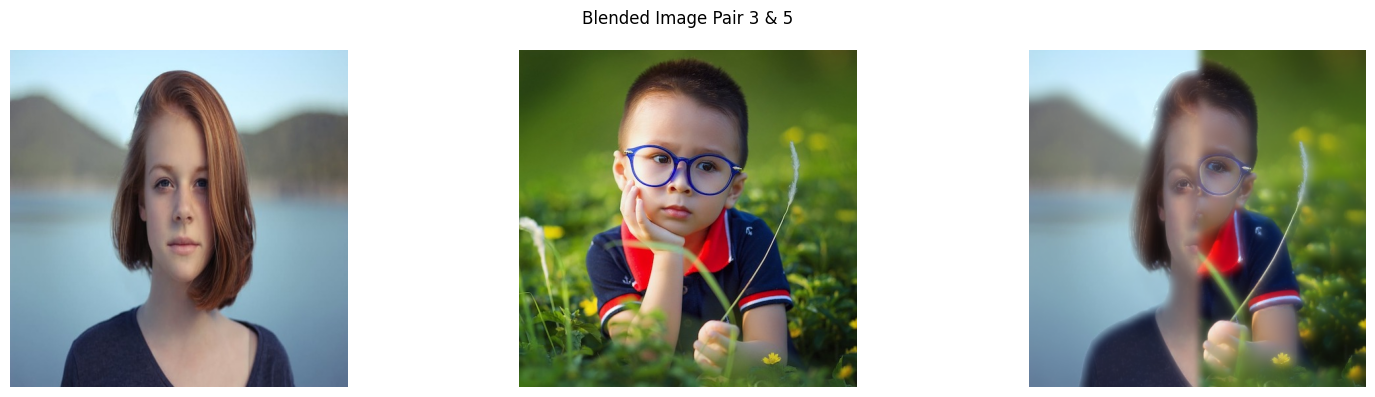

In [ ]:
blended_image = laplacian_pyramid_blend_images(gt_images[3], gt_images[5])
collage = np.array([gt_images[3], gt_images[5], blended_image])
show_image_grid(collage, 1, 3, 'Blended Image Pair 3 & 5', figsize=16)

### Q3 [4 Marks]

Implement Harris and Hessian Corner Detector algorithm from scratch.

You can use following functions from opencv/scipy:

* convolution
* cv2.subtract
* cv2.add
* cv2.resize
* padding

You can follow this article for more explanation:

1. [Harris and Hessian Corner Detector](https://medium.com/jun94-devpblog/cv-10-local-feature-descriptors-harris-and-hessian-corner-detector-7d524888abfd)

# Harris Corner Detector


In [ ]:
# Harris Corner Detector

from scipy.ndimage import convolve
def image_derivative(image):
  if len(image.shape) == 3:
        imag = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  #Image derivative using sobel operator
  Ix=cv2.Sobel(imag,cv2.CV_64F,1,0,ksize=3)
  Iy=cv2.Sobel(imag,cv2.CV_64F,0,1,ksize=3)
  return Ix,Iy

def squares_of_derivatives(Ix,Iy):
  #Computing Squares of derivatives
  Ixx = np.square(Ix)
  Iyy = np.square(Iy)
  Ixy = Ix * Iy
  Sxx=cv2.GaussianBlur(Ixx,(5,5),sigmaX=1.0)
  Syy=cv2.GaussianBlur(Iyy,(5,5),sigmaX=1.0)
  Sxy=cv2.GaussianBlur(Ixy,(5,5),sigmaX=1.0)
  return Sxx,Syy,Sxy


def harris_corner_response(Sxx,Syy,Sxy):
  k = 0.04
  det_M=Sxx*Syy-(Sxy ** 2)
  trace_M=Sxx+Syy
  R=det_M - k * (trace_M ** 2)

  return R


def thresholding(R):
  R_thresh = R > (0.01 * R.max())
  return R_thresh

def Non_max_suppresion(R_thresh,imag):
  corner_image = np.zeros_like(imag)
  corner_image[R_thresh] = 255  # Mark corners in the output image
  return corner_image


def detect_harris_corner(imag):
    corner_image  = None

    Ix,Iy=image_derivative(imag)
    Ixx,Iyy,Ixy=squares_of_derivatives(Ix,Iy)
    R=harris_corner_response(Ixx,Iyy,Ixy)
    R_thresh=thresholding(R)
    corner_image=Non_max_suppresion(R_thresh,imag)
    if corner_image.any() == None:
        return imag

    return corner_image

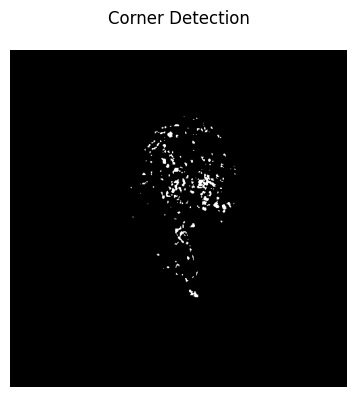

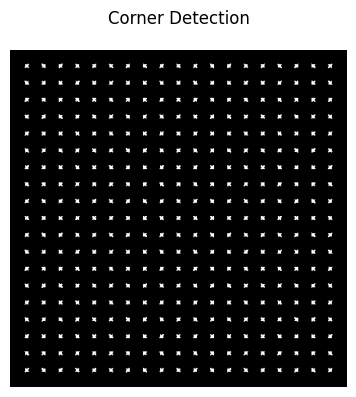

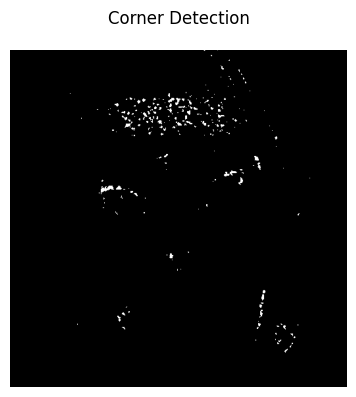

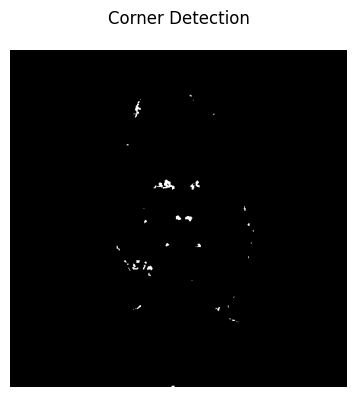

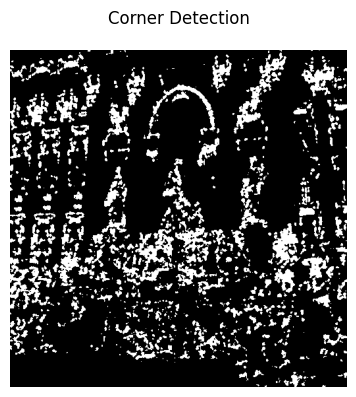

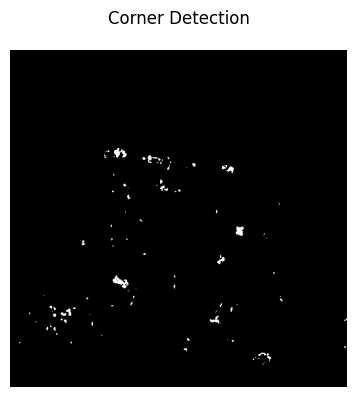

In [ ]:
for image in gt_images:
    corner_image = detect_harris_corner(image)
    show_image_grid(corner_image, 1, 1, 'Corner Detection', figsize=16)

# Hessian corner detector

In [ ]:
#Hesssian detector

def image_second_derivative(image):
    #Second derivatives using Sobel operator for approximation
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # First derivative
    Ix=cv2.Sobel(image,cv2.CV_64F,1,0,ksize=3)
    Iy=cv2.Sobel(image,cv2.CV_64F,0,1,ksize=3)
    # Second derivative

    Ixx=cv2.Sobel(Ix,cv2.CV_64F,1,0,ksize=3)
    Iyy=cv2.Sobel(Iy,cv2.CV_64F,0,1,ksize=3)
    Ixy=cv2.Sobel(Ix,cv2.CV_64F,0,1,ksize=3)

    Ixx=cv2.GaussianBlur(Ixx,(5,5),sigmaX=0.1)
    Iyy=cv2.GaussianBlur(Iyy,(5,5),sigmaX=0.1)
    Ixy=cv2.GaussianBlur(Ixy,(5,5),sigmaX=0.1)

    return Ixx, Iyy, Ixy

def hessian_corner_response(Ixx, Iyy, Ixy):
    # determinant of the Hessian matrix
    det_H = (Ixx * Iyy) - (Ixy ** 2)
    return det_H

def thresholding_hessian(det_H):
    # thresholding to identify strong corner responses
    threshold = 0.01 * np.max(det_H)
    corner_points = det_H > threshold
    return corner_points

def non_max_suppression_hessian(corner_points, image):
    # Non-max suppression
    corner_image = np.zeros_like(image)
    corner_image[corner_points] = 255
    return corner_image

def detect_hessian_corner(image):
    # second derivatives
    Ixx, Iyy, Ixy = image_second_derivative(image)

    # Computation of the corner response using the determinant of the Hessian matrix
    det_H = hessian_corner_response(Ixx, Iyy, Ixy)

    # Threshold the corner response to find strong corner points
    corner_points = thresholding_hessian(det_H)

    #  non-max suppression
    corner_image = non_max_suppression_hessian(corner_points, image)

    return corner_image



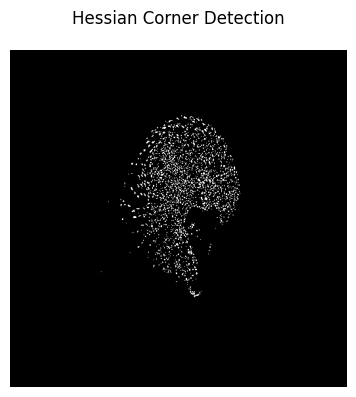

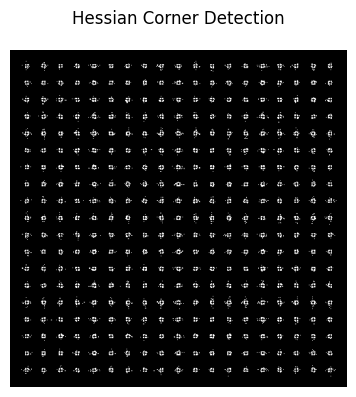

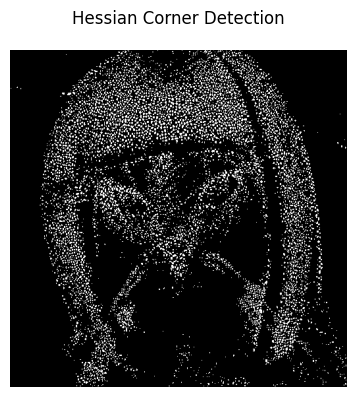

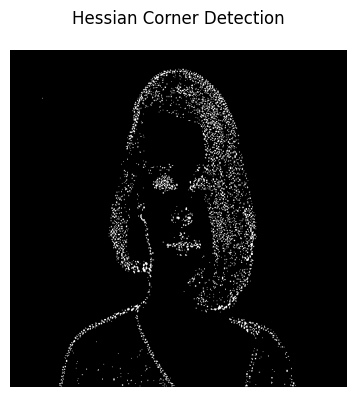

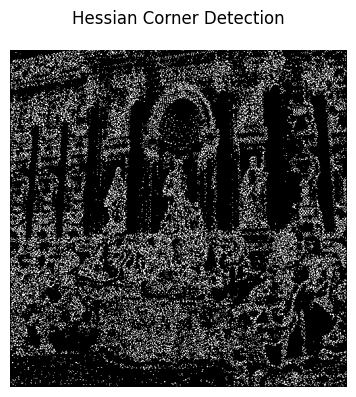

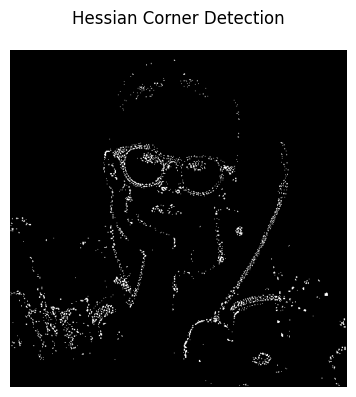

In [ ]:

for image in gt_images:
    corner_image = detect_hessian_corner(image)
    show_image_grid(corner_image, 1, 1, 'Hessian Corner Detection', figsize=16)